In [1]:
# configuring path
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab_Notebooks/time_series
!pwd

/content/drive/MyDrive/Colab_Notebooks/time_series
/content/drive/MyDrive/Colab_Notebooks/time_series


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Importing the Keras libraries and packages
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau,TensorBoard,ModelCheckpoint,EarlyStopping

In [15]:
# load data
df = pd.read_csv('for_time_series_forceasting_pedestrian_count.tsv', sep='\t')
df.rename(columns={'date':'Date'}, inplace=True)
# dataframe hard copy for normalization
df_norm = df.copy()

original data


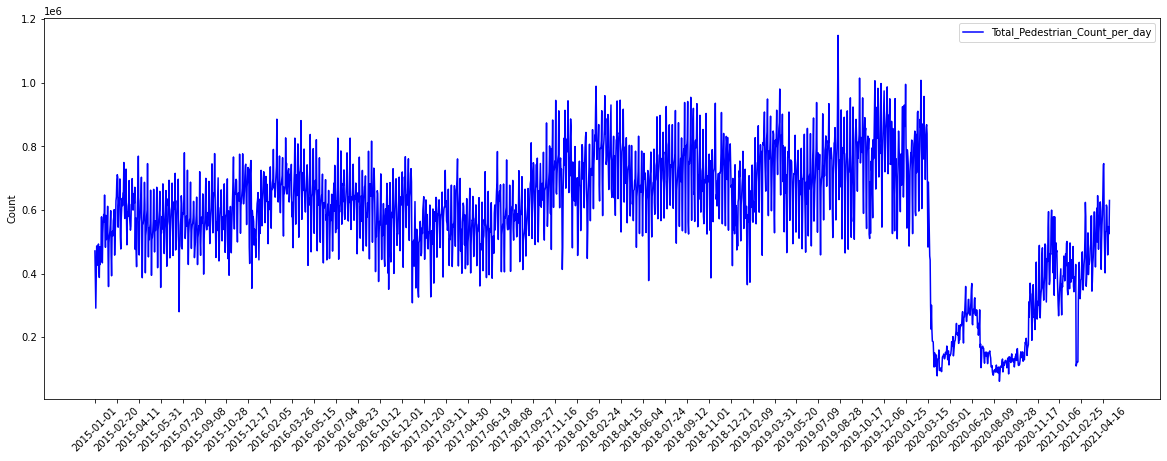

In [16]:
# show pedestrian count each day
print('original data')
plt.figure(figsize = (20, 7))
plt.plot(range(len(df)), df['Total_Pedestrian_Count_per_day'], color='blue', label='Total_Pedestrian_Count_per_day')
plt.xticks(range(0,len(df),50),df['Date'].loc[::50],rotation=45)
plt.ylabel('Count')
plt.legend()
plt.show()


Normalized data


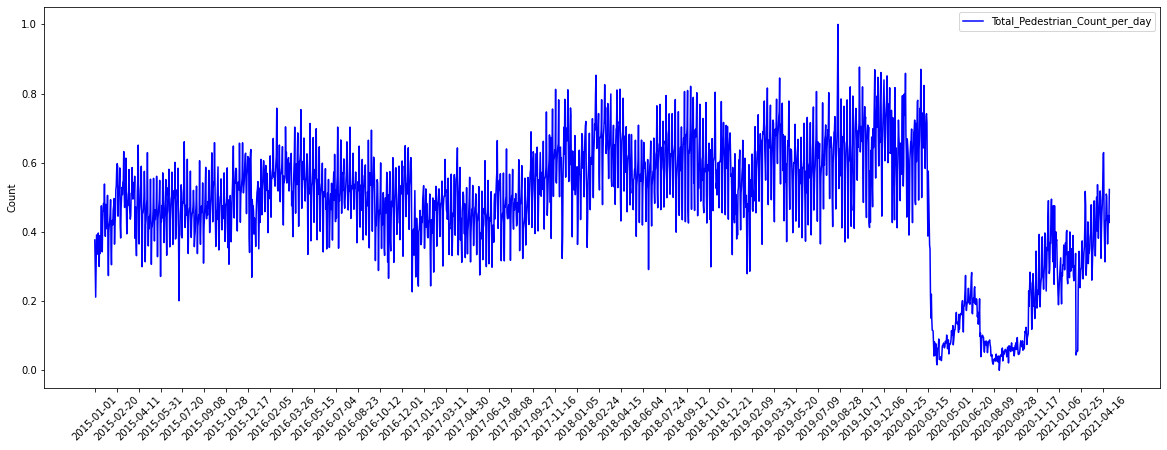

In [17]:
# Data Normalization
scaler = MinMaxScaler()
df_norm.iloc[:,1:] = scaler.fit_transform(df_norm.iloc[:,1:].values)    # normalize feature except the date column
# test_x.iloc[:, 1:] = scaler.transform(test_x.iloc[:, 1:].values)

print('\nNormalized data')
plt.figure(figsize = (20, 7))
plt.plot(range(len(df_norm)), df_norm['Total_Pedestrian_Count_per_day'], color='blue', label='Total_Pedestrian_Count_per_day')
plt.xticks(range(0,len(df_norm),50),df_norm['Date'].loc[::50],rotation=45)
plt.ylabel('Count')
plt.legend()
plt.show()

In [18]:
df_norm

,Date,Maximum temperature (Degree C),Minimum temperature (Degree C),Rainfall amount (millimetres),Daily global solar exposure (MJ/m*m),Public_Holiday,Covid Restrictions,Total_Pedestrian_Count_per_day
0,2015-01-01,0.518841,0.463504,0.000000,0.702454,1.0,0.0,0.376885
1,2015-01-02,0.863768,0.540146,0.000000,0.800613,0.0,0.0,0.301011
2,2015-01-03,0.846377,0.708029,0.000000,0.791411,0.0,0.0,0.211554
3,2015-01-04,0.359420,0.572993,0.076923,0.751534,0.0,0.0,0.294865
4,2015-01-05,0.376812,0.525547,0.000000,0.920245,0.0,0.0,0.391282
...,...,...,...,...,...,...,...,...
2310,2021-04-26,0.257971,0.375912,0.021978,0.226994,0.0,0.0,0.365347
2311,2021-04-27,0.220290,0.408759,0.010989,0.220859,0.0,0.0,0.403672
2312,2021-04-28,0.228986,0.248175,0.007326,0.368098,0.0,0.0,0.447398
2313,2021-04-29,0.272464,0.277372,0.000000,0.368098,0.0,0.0,0.426576


In [19]:
### test n predict

n_past = 150           # no of past days used to predict the future
n_future = 21           # no of future days being predicted. Data from source is 2 weeks old


x_train = []
y_train = []

for i in range(n_past, len(df_norm) -n_future +1):
	x_train.append(df_norm.iloc[i-n_past:i, 1:].values) # use all column apart from date as feature
	y_train.append(df_norm.iloc[i:i+n_future,-1]) # considering last column as target label

x_train, y_train = np.array(x_train), np.array(y_train)
print('Train data shape: ', x_train.shape)
print('Train Target shape: ', y_train.shape)

Train data shape:  (2145, 150, 7)
Train Target shape:  (2145, 21)


In [20]:
 # test on last N days
LAST_N_DAYS = 30

train_x = x_train[:-LAST_N_DAYS,:,:]
train_y = y_train[:-LAST_N_DAYS,:]
print('Train data shape: ', train_x.shape)
print('Train Target shape: ', train_y.shape)

test_x = x_train[-LAST_N_DAYS:,:,:]
test_y = y_train[-LAST_N_DAYS:,:]
print('Test data shape: ', test_x.shape)
print('Test Target shape: ', test_y.shape)

Train data shape:  (2115, 150, 7)
Train Target shape:  (2115, 21)
Test data shape:  (30, 150, 7)
Test Target shape:  (30, 21)


# Simple RNN

Add SimpleRNN model here

In [21]:
def get_model():
  np.random.seed(36)
  model = Sequential()
  model.add(SimpleRNN(50,input_shape=(train_x.shape[1], train_x.shape[2])))
  model.add(Dropout(0.3))
  model.add(Dense(256))
  model.add(Dense(train_y.shape[1]))
  return model

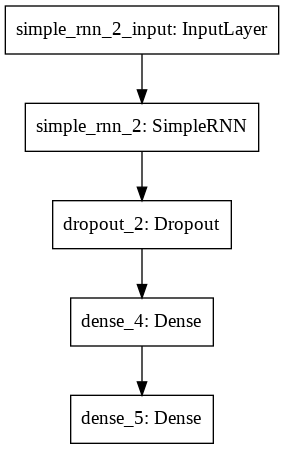

In [22]:
# Model Visualization
model = get_model()
plot_model(model)

In [23]:
model = get_model()
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, verbose=0, mode='min', min_delta=0.0001, min_lr=0.000000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', min_delta=0.00001)

tensorboard = TensorBoard(log_dir="logs",write_graph=True)
filepath = './best_rnn_model.hdf5'
model_check_point = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

LR = 1e-4
EPOCH = 200
opt = Adam(lr=LR, decay=LR/EPOCH)
# opt = Adam(lr=LR)
# opt = RMSprop(lr=LR)
model.compile(optimizer=opt, loss='mae')

In [24]:
model_history = model.fit(
                            train_x, train_y, 
                            epochs=EPOCH, 
                            batch_size=32, 
                            # validation_data=(test_x, test_y)
                            validation_split=.2,
                            callbacks = [reduce_lr_on_plateau, tensorboard, model_check_point,early_stopping]
                        )

Epoch 1/200
53/53 [==============================] - 6s 99ms/step - loss: 0.4405 - val_loss: 0.2328
Epoch 2/200
53/53 [==============================] - 4s 84ms/step - loss: 0.1825 - val_loss: 0.2255
Epoch 3/200
53/53 [==============================] - 5s 86ms/step - loss: 0.1577 - val_loss: 0.2163
Epoch 4/200
53/53 [==============================] - 4s 84ms/step - loss: 0.1440 - val_loss: 0.2080
Epoch 5/200
53/53 [==============================] - 4s 81ms/step - loss: 0.1366 - val_loss: 0.2027
Epoch 6/200
53/53 [==============================] - 4s 82ms/step - loss: 0.1253 - val_loss: 0.1977
Epoch 7/200
53/53 [==============================] - 4s 82ms/step - loss: 0.1176 - val_loss: 0.1890
Epoch 8/200
53/53 [==============================] - 4s 83ms/step - loss: 0.1115 - val_loss: 0.1835
Epoch 9/200
53/53 [==============================] - 4s 82ms/step - loss: 0.1050 - val_loss: 0.1842
Epoch 10/200
53/53 [==============================] - 4s 85ms/step - loss: 0.0992 - val_loss: 0.1766

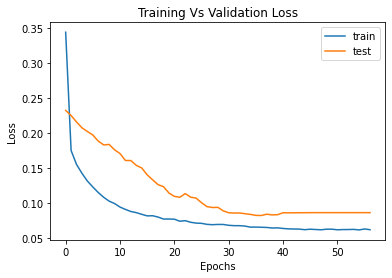

In [25]:
# Plot training loss vs validation loss
plt.title('Training Vs Validation Loss')
plt.plot(model_history.history['loss'], label='train')
plt.plot(model_history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# load best rnn model
rnn_best_model = keras.models.load_model(filepath)

In [ ]:
# report error. Benchmark for reference
train_pred = model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)

train MAE error for standard averaging: 0.04625543658630555
test MAE error for standard averaging: 0.04963793676829961


In [27]:
# report error
train_pred = rnn_best_model.predict(train_x)
err = np.mean(np.abs(train_y-train_pred))
print('train MAE error for standard averaging:', err)

test_pred = rnn_best_model.predict(test_x)
err = np.mean(np.abs(test_y-test_pred))
print('test MAE error for standard averaging:', err)

train MAE error for standard averaging: 0.060441675954933334
test MAE error for standard averaging: 0.06384768124508759


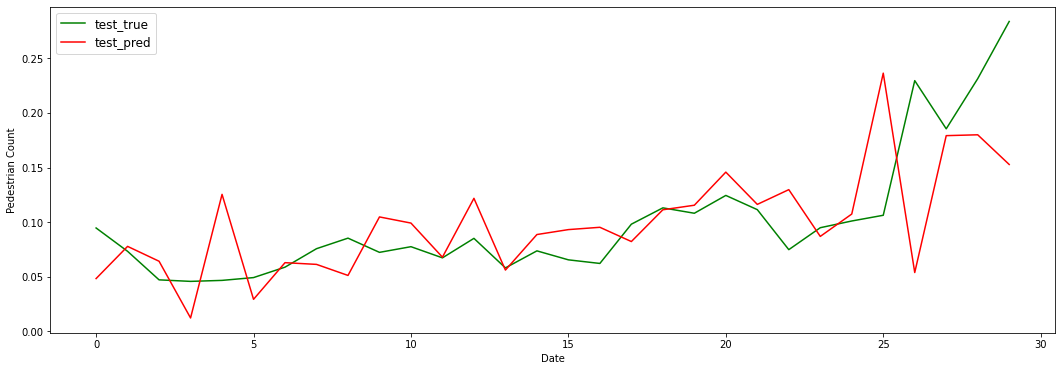

In [ ]:
plt.figure(figsize = (18,6))
# plt.plot(train_y,color='b',label='True')
# plt.plot(train_pred,color='orange',label='Predicted')
# plt.xlabel('Date')
# plt.ylabel('Close')
# plt.legend(fontsize=12)
# plt.show()
plt.plot(test_y,color='g',label='test_true')
plt.plot(test_pred,color='r',label='test_pred')
plt.xlabel('Date')
plt.ylabel('Pedestrian Count')
plt.legend(fontsize=12)
plt.show()

In [81]:
from datetime import datetime, timedelta

# predict next n days
to_pred = np.expand_dims(test_x[-1],axis=0)
prediction = model.predict(to_pred)

# Denormalize the scaled values
n_pred_scaled = df_norm.iloc[-1:,1:-1]
# repeat the dataframe n times to align with n days prediction
n_pred_scaled = n_pred_scaled.loc[n_pred_scaled.index.repeat(n_future)].reset_index(drop=True)
n_pred_scaled['target'] = prediction[0]
n_pred_scaled_predicted_denorm = scaler.inverse_transform(n_pred_scaled)[:,-1]

# dataframe for visualization
pred_df = pd.DataFrame(data={'Prediction':n_pred_scaled_predicted_denorm})
pred_df['Prediction'] = pred_df['Prediction'].astype(int)
last_date = df.iloc[-1,0]
last_date_obj = datetime.strptime(last_date, '%Y-%m-%d')
today = datetime.now()
date_list = []
for i in range(n_future):
  next_n_days = last_date_obj - timedelta(days=-i-1)
  date_list.append(next_n_days.strftime('%Y-%m-%d'))
pred_df['Date'] = date_list
pred_df = pred_df[['Date','Prediction']]
print(pred_df)

          Date  Prediction
0   2021-05-01      571271
1   2021-05-02      449506
2   2021-05-03      428353
3   2021-05-04      457337
4   2021-05-05      468667
5   2021-05-06      531579
6   2021-05-07      621165
7   2021-05-08      585414
8   2021-05-09      449818
9   2021-05-10      441588
10  2021-05-11      472998
11  2021-05-12      468796
12  2021-05-13      541805
13  2021-05-14      642357
14  2021-05-15      586457
15  2021-05-16      461530
16  2021-05-17      443537
17  2021-05-18      470368
18  2021-05-19      465818
19  2021-05-20      543237
20  2021-05-21      619695


In [82]:
# merging the original dataset and predicted for website integration
pred_df.rename(columns={'Prediction':'Total_Pedestrian_Count_per_day'}, inplace=True)
final_df = df[['Date','Total_Pedestrian_Count_per_day']].append(pred_df)
final_df

21


,Date,Total_Pedestrian_Count_per_day
0,2015-01-01,471563
1,2015-01-02,389048
2,2015-01-03,291761
3,2015-01-04,382364
4,2015-01-05,487220
...,...,...
16,2021-05-17,443537
17,2021-05-18,470368
18,2021-05-19,465818
19,2021-05-20,543237


In [ ]:
def evaluate_model(y_true, y_predicted):
    scores = []
    
    #calculate scores for each day
    for i in range(y_true.shape[1]):
        mse = mean_squared_error(y_true[:, i], y_predicted[:, i])
        rmse = np.sqrt(mse)
        scores.append(rmse)
    
    #calculate score for whole prediction
    total_score = 0
    for row in range(y_true.shape[0]):
        for col in range(y_predicted.shape[1]):
            total_score = total_score + (y_true[row, col] - y_predicted[row, col])**2
    total_score = np.sqrt(total_score/(y_true.shape[0]*y_predicted.shape[1]))
    
    return total_score, scores

In [ ]:
y_pred = reg.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred)
y_true = y_scaler.inverse_transform(y_test)
evaluate_model(y_true, y_pred)
